## 3. Data Preprocessing & Storage

- Develop data cleaning pipelines for each data source
- Handle missing values through appropriate imputation techniques
- Normalize data from different sources and convert to consistent units
- Implement temporal alignment for time-series data
- Create georeferenced dataset structure for spatial analysis
- Design CSV schema for storing processed data
- Document data lineage and preprocessing steps
- Implement data validation checks for consistency

In [55]:
#Import Libraries 
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

Load Climate Data

In [56]:
# Path to climate data
climate_path = Path("data/raw/climate/")

# Mapping: filename → new column name
climate_files = {
    "observed-annual-average_temp.csv": "avg_mean_temp",
    "observed-annual-average-min-temp.csv": "avg_min_temp",
    "observed-annual-average-max-temp.csv": "avg_max_temp",
    "observed-annual-relative-humidity.csv": "relative_humidity",
    "observed_annual-average-largest-1-day-precipitation.csv": "precipitation_max"
}

# Load and build wide-format dataframe
climate_data = pd.DataFrame({
    col: pd.read_csv(climate_path / fname).set_index("Category")["Annual Mean"]
    for fname, col in climate_files.items()
}).reset_index().rename(columns={"Category": "year"})

# Show result
print(climate_data.head())


   year  avg_mean_temp  avg_min_temp  avg_max_temp  relative_humidity  \
0  1950          11.24          6.66         15.71              74.93   
1  1951          11.21          6.53         15.84              74.99   
2  1952          10.84          6.42         15.23              78.17   
3  1953          10.90          6.42         15.38              77.45   
4  1954          11.48          6.71         16.24              70.61   

   precipitation_max  
0              88.27  
1              91.14  
2              74.80  
3             102.32  
4             125.67  


In [57]:
#load rainfall data
rainfall = pd.read_csv(climate_path / "npl-rainfall-adm2-full.csv")

# Drop header row if duplicated and convert types
rainfall = rainfall.drop(index=0)
rainfall['date'] = pd.to_datetime(rainfall['date'])
rainfall['rfh'] = pd.to_numeric(rainfall['rfh'], errors='coerce')

# Compute annual mean rainfall
rainfall['year'] = rainfall['date'].dt.year
annual_rain = rainfall.groupby('year')['rfh'].mean().reset_index(name='annual_rainfall')

# Merge with climate_data
climate_data = climate_data.merge(annual_rain, on='year', how='outer')

# Impute missing climate values with column mean
climate_data.fillna(climate_data.mean(numeric_only=True), inplace=True)

# Display combined climate data
climate_data.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11548\1384110716.py:2: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  rainfall = pd.read_csv(climate_path / "npl-rainfall-adm2-full.csv")


,year,avg_mean_temp,avg_min_temp,avg_max_temp,relative_humidity,precipitation_max,annual_rainfall
0,1950,11.24,6.66,15.71,74.93,88.27,41.292567
1,1951,11.21,6.53,15.84,74.99,91.14,41.292567
2,1952,10.84,6.42,15.23,78.17,74.80,41.292567
3,1953,10.90,6.42,15.38,77.45,102.32,41.292567
4,1954,11.48,6.71,16.24,70.61,125.67,41.292567


Load Socioeconomic data

In [58]:
# Load socio-economic data in one line
data_1 = pd.read_csv(Path("data/raw/socio-economic/eco-socio-env-health-edu-dev-energy_npl.csv"))

# Display preview
print(data_1.head())

  Country Name Country ISO3  Year  \
0        Nepal          NPL  1983   
1        Nepal          NPL  2022   
2        Nepal          NPL  2021   
3        Nepal          NPL  2020   
4        Nepal          NPL  2019   

                                      Indicator Name     Indicator Code  \
0  Fertilizer consumption (% of fertilizer produc...  AG.CON.FERT.PT.ZS   
1  Fertilizer consumption (kilograms per hectare ...     AG.CON.FERT.ZS   
2  Fertilizer consumption (kilograms per hectare ...     AG.CON.FERT.ZS   
3  Fertilizer consumption (kilograms per hectare ...     AG.CON.FERT.ZS   
4  Fertilizer consumption (kilograms per hectare ...     AG.CON.FERT.ZS   

        Value  
0  129.065744  
1   67.843176  
2  112.610654  
3  115.325540  
4   97.005587  


In [63]:
# Map of indicators to simplified column names
indicators = {
    'Agricultural land (sq. km)': 'agri_land_area',
    'Permanent cropland (% of land area)': 'cropland_pct',
    'Population density (people per sq. km of land area)': 'population_density',
    'Fertilizer consumption (kilograms per hectare of arable land)': 'fertilizer_kg_per_ha'
}

# Filter and reshape data
filtered = (
    data_1[data_1['Indicator Name'].isin(indicators.keys())]
    .loc[:, ['Year', 'Indicator Name', 'Value']]
)

# Handle duplicate Year-Indicator pairs by averaging
filtered = (
    filtered
    .groupby(['Indicator Name', 'Year'], as_index=False)
    .agg(Value=('Value', 'mean'))
)

# Rename indicators and pivot to wide format
filtered['Indicator Name'] = filtered['Indicator Name'].map(indicators)
socio_df = filtered.pivot(index='Year', columns='Indicator Name', values='Value').reset_index()

# Impute missing values with median for each column
for col in socio_df.columns:
    if col != 'Year':
        socio_df.fillna({col: socio_df[col].median()}, inplace=True)

# Rename Year column to year
socio_df.rename(columns={'Year': 'year'}, inplace=True)

# Display processed socio-economic data
socio_df.head()

Indicator Name,year,agri_land_area,cropland_pct,fertilizer_kg_per_ha,population_density
0,1961,35530.0,0.174825,0.082503,72.156615
1,1962,35530.0,0.174825,0.238649,73.574238
2,1963,35630.0,0.174825,0.347467,75.033692
3,1964,35530.0,0.174825,0.565891,76.548196
4,1965,35530.0,0.174825,0.614064,78.135741


In [64]:
combined_df = pd.merge(climate_data, socio_df, on='year', how='outer')
# Final imputation of any remaining missing values
combined_df.fillna(combined_df.mean(numeric_only=True), inplace=True)

combined_df.head()


,year,avg_mean_temp,avg_min_temp,avg_max_temp,relative_humidity,precipitation_max,annual_rainfall,agri_land_area,cropland_pct,fertilizer_kg_per_ha,population_density
0,1950,11.24,6.66,15.71,74.93,88.27,41.292567,40334.66129,0.537348,27.372378,141.571356
1,1951,11.21,6.53,15.84,74.99,91.14,41.292567,40334.66129,0.537348,27.372378,141.571356
2,1952,10.84,6.42,15.23,78.17,74.80,41.292567,40334.66129,0.537348,27.372378,141.571356
3,1953,10.90,6.42,15.38,77.45,102.32,41.292567,40334.66129,0.537348,27.372378,141.571356
4,1954,11.48,6.71,16.24,70.61,125.67,41.292567,40334.66129,0.537348,27.372378,141.571356


In [65]:
# Final check for missing values
print(combined_df.isnull().sum())

year                    0
avg_mean_temp           0
avg_min_temp            0
avg_max_temp            0
relative_humidity       0
precipitation_max       0
annual_rainfall         0
agri_land_area          0
cropland_pct            0
fertilizer_kg_per_ha    0
population_density      0
dtype: int64


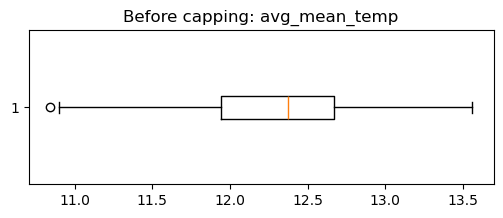

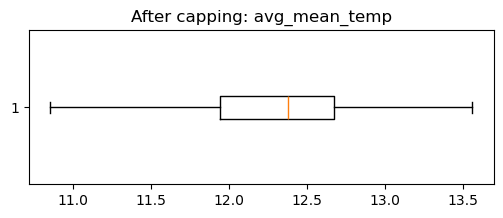

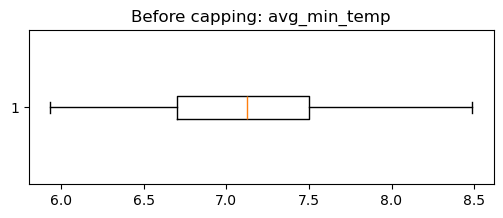

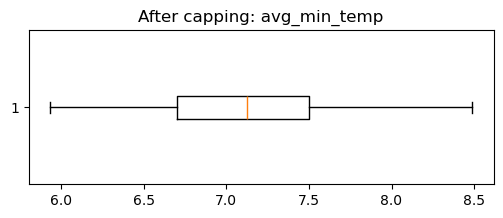

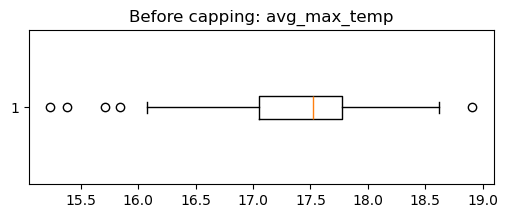

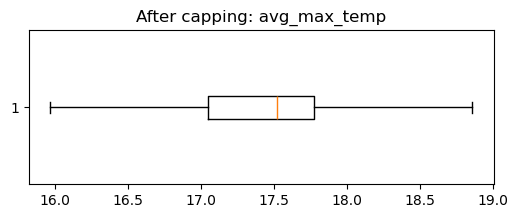

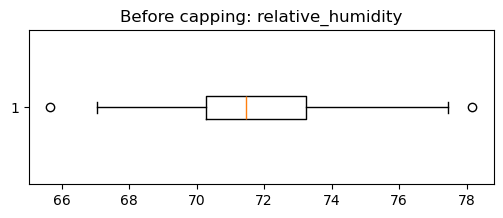

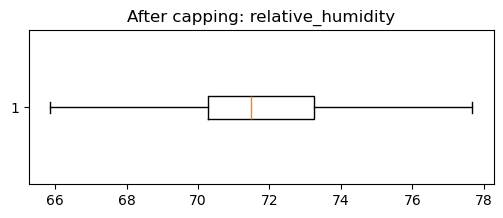

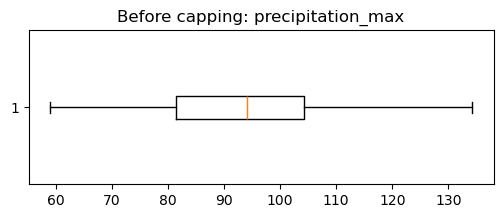

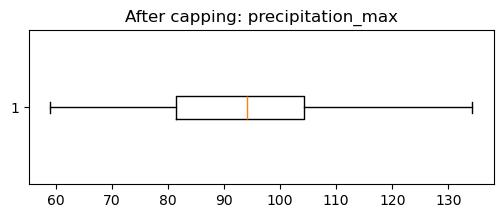

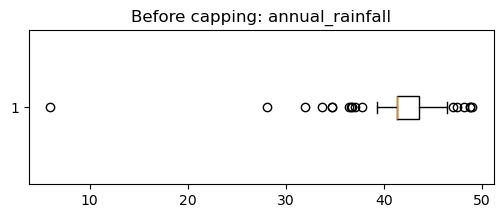

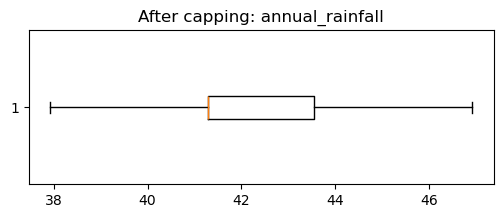

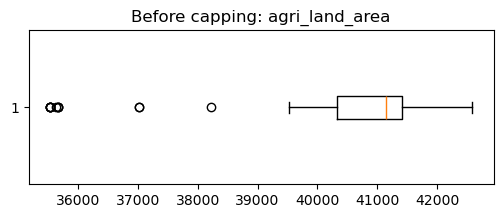

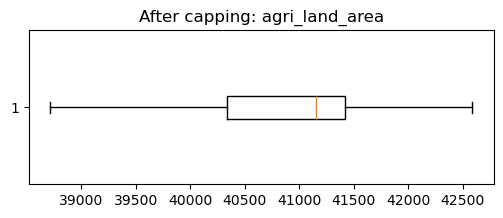

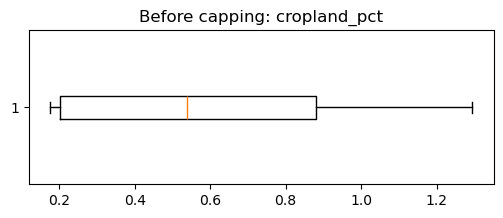

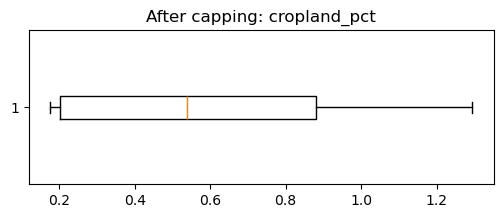

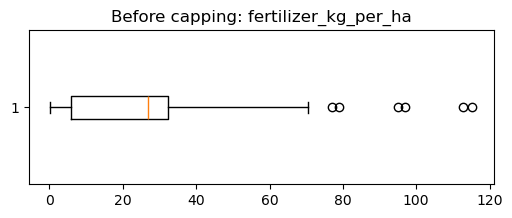

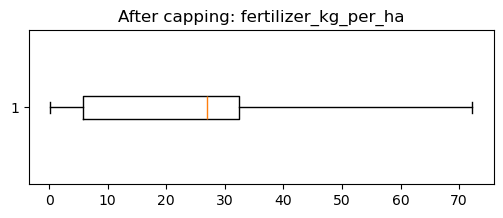

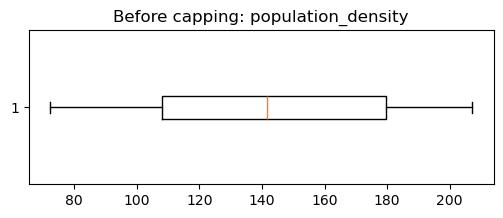

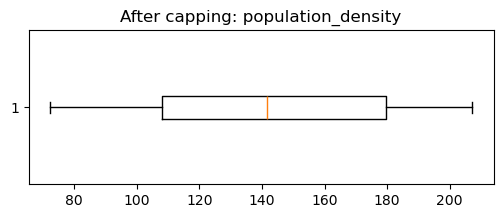

In [66]:
num_cols = combined_df.select_dtypes(include=[np.number]).columns.drop('year')

# Function to cap outliers based on IQR
# %%
def cap_outliers(series: pd.Series) -> pd.Series:
    """
    Caps values in a Series at 1.5 * IQR from Q1 and Q3.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return series.clip(lower, upper)

# Apply capping and visualize before/after
for col in num_cols:
    # Plot before capping
    plt.figure(figsize=(6, 2))
    plt.boxplot(combined_df[col].dropna(), vert=False)
    plt.title(f"Before capping: {col}")
    plt.show()

    # Cap outliers
    combined_df[col] = cap_outliers(combined_df[col])

    # Plot after capping
    plt.figure(figsize=(6, 2))
    plt.boxplot(combined_df[col].dropna(), vert=False)
    plt.title(f"After capping: {col}")
    plt.show()

In [68]:
output_path = Path("data")
output_path.mkdir(parents=True, exist_ok=True)
combined_df.to_csv(output_path / "combined_climate_data.csv", index=False)

print("Processed data saved to:", output_path / "combined_climate_data.csv")

Processed data saved to: data\combined_climate_data.csv


In [26]:
 #Load combined data
c_df = pd.read_csv("data/combined_data.csv")

# Show top 30 rows by a key column (e.g., annual_rainfall)
top30 = df.sort_values(by='annual_rainfall', ascending=False).head(30)
print("🔝 Top 30 rows by annual_rainfall:\n", top30)

# Check for missing values
missing_count = df.isnull().sum()
missing_percent = df.isnull().mean() * 100

print("\n📊 Missing value count per column:\n", missing_count)
print("\n📉 Missing value percentage per column:\n", missing_percent.round(2))


🔝 Top 30 rows by annual_rainfall:
     year  avg_mean_temp  avg_min_temp  avg_max_temp  relative_humidity  \
34  1984          12.40          6.80       17.7400              69.83   
71  2021          13.09          8.26       18.1800              74.83   
35  1985          12.52          7.12       17.5900              70.69   
37  1987          12.56          6.98       17.8600              69.66   
63  2013          12.71          7.50       17.6600              72.32   
50  2000          12.30          7.13       17.3200              74.00   
70  2020          12.47          7.76       17.4300              75.18   
38  1988          12.98          7.44       18.2100              69.76   
40  1990          12.42          7.13       17.5200              72.74   
57  2007          12.85          7.73       17.7600              73.11   
54  2004          12.66          7.44       17.6500              73.79   
61  2011          12.51          7.43       17.5300              73.36   
31 